# Detekcja Porzuconych Obiektów

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob

from AOD import ObjectDetector, ObjectTracker, detect_static_objects, get_reference_frame

## Konfiguracja

In [11]:
VIDEO_NUM = 1
VIDEO_PATH = f'Videos/Video{VIDEO_NUM}.avi'
OUTPUT_VIDEO_PATH = f'Outputs/AOD_Video{VIDEO_NUM}.avi'
os.makedirs('Outputs', exist_ok=True)
REFERENCE_FRAME_NUM = 1  

MIN_OBJECT_AREA = 50
MAX_OBJECT_AREA = 2000

MOG2_HISTORY = 300
MOG2_VAR_THRESHOLD = 16
MOG2_DETECT_SHADOWS = True

IOU_THRESHOLD = 0.3
IOD_FILTER_THRESHOLD = 0.1
STATIONARY_TIME_THRESHOLD = 300  

## Główne przetwarzanie

In [12]:
cap = cv2.VideoCapture(VIDEO_PATH)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video: {frame_width}x{frame_height} @ {fps} FPS")
print(f"Total frames: {total_frames} ({total_frames/fps:.1f} seconds)")

frames_base = f'Frames/Video{VIDEO_NUM}/'
os.makedirs(frames_base, exist_ok=True)

Video: 640x480 @ 29 FPS
Total frames: 2189 (75.5 seconds)


In [13]:
reference_frame = get_reference_frame(cap, REFERENCE_FRAME_NUM)

backSub = cv2.createBackgroundSubtractorMOG2(
    history=MOG2_HISTORY,
    varThreshold=MOG2_VAR_THRESHOLD,
    detectShadows=MOG2_DETECT_SHADOWS
)

Reference frame 1 loaded


In [14]:
detector = ObjectDetector(min_area=MIN_OBJECT_AREA, max_area=MAX_OBJECT_AREA)
static_tracker = ObjectTracker(iou_threshold=IOU_THRESHOLD, stationary_threshold=STATIONARY_TIME_THRESHOLD)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (frame_width, frame_height))

In [15]:
frame_count = 0
stats = {
    'moving_objects': [],
    'static_candidates': [],
    'abandoned_objects': []
}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    # MOG2 
    fgMask = backSub.apply(frame)
    fgMask[fgMask == 127] = 0
    
    # Czyszczenie od szumów
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel, iterations=2)
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Detekcja obiektów
    moving_objects = detector.detect_objects(fgMask)
    static_candidates = detect_static_objects(frame, reference_frame, min_area=MIN_OBJECT_AREA)
    
    # Filtracja statycznych obiektów przez IoU
    # static_candidates zawiera:
    # 1. Plecak (DOBRY - naprawdę statyczny)
    # 2. Osoba która stoi (ZŁY - zaraz się poruszy)
    static_objects = []
    for static_obj in static_candidates:
        is_moving = False
        for moving_obj in moving_objects:
            iou = static_tracker.calculate_iou(static_obj['bbox'], moving_obj['bbox'])
            if iou > IOD_FILTER_THRESHOLD:
                is_moving = True
                break
        
        if not is_moving:
            static_objects.append(static_obj)
    
    tracked_static = static_tracker.update(static_objects, frame_count)
    
    # Rysuj poruszające się obiekty (zielony)
    for obj in moving_objects:
        x, y, w, h = obj['bbox']
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, "MOVING", (x, y-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Rysuj obiekty statyczne z kolorowaniem według czasu
    abandoned_count = 0
    for obj in tracked_static:
        x, y, w, h = obj['bbox']
        center = obj['center']
        
        if obj['is_stationary']:  # Czerwony - porzucony
            abandoned_count += 1
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 4)
            
            # Alert banner
            cv2.rectangle(frame, (x, y-60), (x+280, y), (0, 0, 255), -1)
            cv2.putText(frame, "! ABANDONED OBJECT !", (x+5, y-35), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            cv2.putText(frame, f"ID:{obj['id']} Time:{obj['frames_stationary']}f", (x+5, y-15), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
            
            # Migający punkt
            if (frame_count // 5) % 2 == 0:
                cv2.circle(frame, center, 10, (0, 0, 255), -1)
                cv2.circle(frame, center, 15, (255, 255, 255), 2)
        
        else:  # Żółty 
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
            cv2.putText(frame, f"Static {obj['frames_stationary']}f", (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
    
    # Info bar
    info_bg = frame.copy()
    cv2.rectangle(info_bg, (0, 0), (frame_width, 60), (0, 0, 0), -1)
    frame = cv2.addWeighted(frame, 0.7, info_bg, 0.3, 0)
    
    cv2.putText(frame, f"Frame: {frame_count}/{total_frames}", (10, 25), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    cv2.putText(frame, f"ABANDONED: {abandoned_count} | Moving: {len(moving_objects)}", (10, 50), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
    out.write(frame)
    
    stats['moving_objects'].append(len(moving_objects))
    stats['static_candidates'].append(len(static_candidates))
    stats['abandoned_objects'].append(abandoned_count)
    
    # Progress
    if frame_count % 200 == 0:
        print(f"Processed {frame_count}/{total_frames} frames ({100*frame_count/total_frames:.1f}%)")

cap.release()
out.release()

Processed 200/2189 frames (9.1%)
Processed 400/2189 frames (18.3%)
Processed 600/2189 frames (27.4%)
Processed 800/2189 frames (36.5%)
Processed 1000/2189 frames (45.7%)
Processed 1200/2189 frames (54.8%)
Processed 1400/2189 frames (64.0%)
Processed 1600/2189 frames (73.1%)
Processed 1800/2189 frames (82.2%)
Processed 2000/2189 frames (91.4%)


## Wizualizacja statystyk

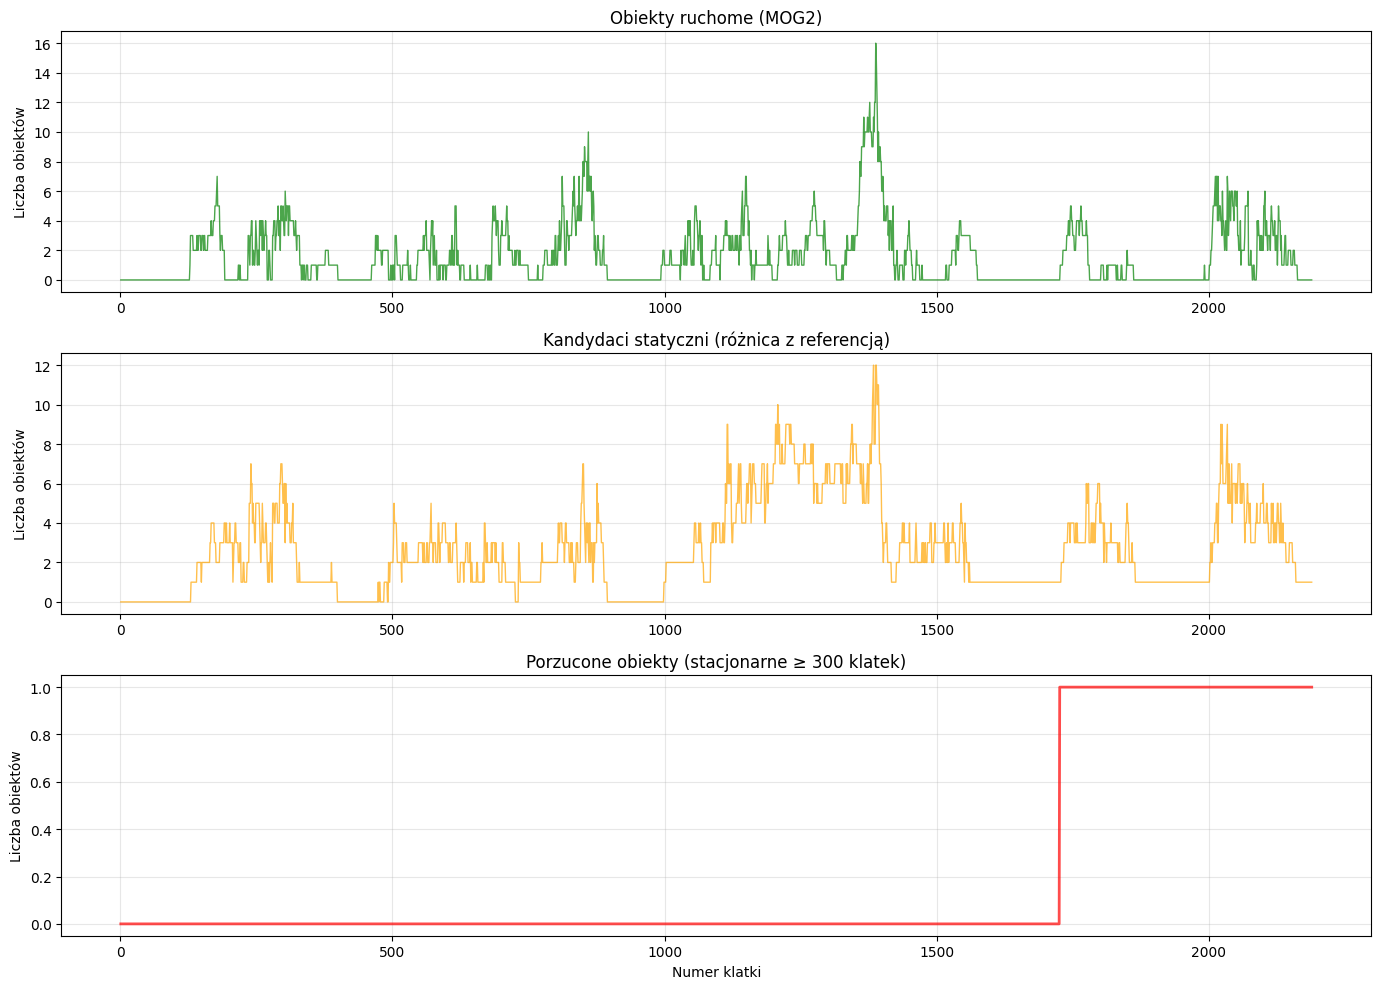

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

frames = list(range(1, len(stats['moving_objects']) + 1))

axes[0].plot(frames, stats['moving_objects'], color='green', alpha=0.7, linewidth=1)
axes[0].set_ylabel('Liczba obiektów')
axes[0].set_title('Obiekty ruchome (MOG2)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(frames, stats['static_candidates'], color='orange', alpha=0.7, linewidth=1)
axes[1].set_ylabel('Liczba obiektów')
axes[1].set_title('Kandydaci statyczni (różnica z referencją)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(frames, stats['abandoned_objects'], color='red', alpha=0.7, linewidth=2)
axes[2].set_xlabel('Numer klatki')
axes[2].set_ylabel('Liczba obiektów')
axes[2].set_title(f'Porzucone obiekty (stacjonarne ≥ {STATIONARY_TIME_THRESHOLD} klatek)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()